In [79]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from scipy.stats import multivariate_normal as mvn
import seaborn as sns

In [80]:


# Task 1: Load data

data = np.loadtxt('rc_Q_V.txt', delimiter=',', skiprows=1)

H = data[:, 0]
Q = data[:, 1]

nd = len(H)
n = 2

# Task 2: Analytically compute mean and variance of posterior

A = np.zeros((nd, n))
Gamma = np.zeros((nd, nd))
m0 = np.zeros(n)
Sigma0 = np.array([[10, 0], [0, 10]])


for index, (h, q) in enumerate(zip(H, Q)):
    A[index] = [1, np.log(h)]
    Gamma[index, index] = 0.03 * np.log(q)

m = m0 + Sigma0 @ A.T @ np.linalg.inv(Gamma + A @ Sigma0 @ A.T) @ (Q - A @ m0)
Sigma = Sigma0 - Sigma0 @ A.T @ np.linalg.inv(Gamma + A @ Sigma0 @ A.T) @ A @ Sigma0

print(f"m: {m}")
print(f"Sigma: {Sigma}")

# Task 3: Create functions to compute prior, likelihood and their product

def prior(m0, Sigma0, x):
    # proportionality constant
    # proportionality_constant = 1/((2 * np.pi) ** (n/2) * np.linalg.det(Sigma0) ** 0.5)
    return np.exp(-0.5 * (x - m0).T @ np.linalg.inv(Sigma0) @ (x - m0))

def likelihood(A, Gamma, x, log_q):
    #! log_q used instead of q
    # proportionality constant
    # proportionality_constant = 1/((2 * np.pi) ** (nd/2) * np.linalg.det(Gamma) ** 0.5)
    return np.exp(-0.5 * (log_q - A @ x).T @ np.linalg.inv(Gamma) @ (log_q - A @ x))

def prod_prior_likelihood(m0, Sigma0, A, Gamma, x, log_q):
    return prior(m0, Sigma0, x) * likelihood(A, Gamma, x, log_q)

m: [-6215.58634328  2031.08491973]
Sigma: [[ 2.35805922 -0.66433955]
 [-0.66433955  0.18859052]]


In [81]:
# Task 4: Starting from the code in random_walk_metropolis.py, set up the RWM algorithm

def RWMA(prop_var, burn_in_ratio, noise_level):

    #initialize Gamma with noise level input
    Gamma = np.zeros((nd, nd))
    for index, (h, q) in enumerate(zip(H, Q)):
        Gamma[index, index] = noise_level * np.log(q)

    N = 20000  # number of desired samples in the chain
    x0 = np.zeros(n)  # starting point
    #! dens not used anymore right?
    #!dens = mvn(mean=np.zeros(n), cov=np.eye(n)).pdf  # density to sample from


    def proposal():
        return rnd.multivariate_normal(mean=np.zeros(n), cov=prop_var*np.eye(n))


    samples = np.empty((N, n))  # storage for generated samples
    samples[0, :] = x0  # first element in the chain is x0

    x = x0  # initialization
    dens_x = prod_prior_likelihood(m0, Sigma0, A, Gamma, x, np.log(Q))
    accptd = 0  # number of accepted proposals

    for j in range(1, N):
        eps = proposal()
        x_ = x + eps
        dens_x_ = prod_prior_likelihood(m0, Sigma0, A, Gamma, x_, np.log(Q))

        accpt_prob = np.min([1, dens_x_/dens_x])

        if accpt_prob >= rnd.random():
            # accept
            x = x_
            dens_x = dens_x_
            accptd += 1

        samples[j, :] = x

    # if j % 100 == 0:
    #     # Print acceptance rate every 100th step
    #     print("Acceptance rate: %f" % (accptd/j))

    np.savetxt('samples.txt', samples)

    plt.figure()
    plt.plot(range(1, N+1), samples[:, 0])  # plot first component of all chain elements
    plt.plot(range(1, N+1), samples[:, 1])  # plot first component of all chain elements
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title('Samples')
    plt.tight_layout()
    plt.show()

    # Burn-in period implemented here
   
    burn_in = int(N * burn_in_ratio)
    samples_after_burn_in = samples[burn_in:]


    fig, axs = plt.subplots(1, 2)
    axs[0].hist(samples_after_burn_in[:, 0], bins=50, density=True, alpha=0.6, label="First component")
    sns.kdeplot(samples_after_burn_in[:, 0], ax=axs[0], color='blue')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Density')
    axs[0].set_title('Histogram of First Component')
    axs[0].legend()

    axs[1].hist(samples_after_burn_in[:, 1], bins=50, density=True, alpha=0.6, label="Second component")
    sns.kdeplot(samples_after_burn_in[:, 1], ax=axs[1], color='blue')
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Density')
    axs[1].set_title('Histogram of Second Component')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    return samples_after_burn_in

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_19965/2356949021.py:32: RuntimeWarning: invalid value encountered in scalar divide
  accpt_prob = np.min([1, dens_x_/dens_x])
/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_19965/2356949021.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  accpt_prob = np.min([1, dens_x_/dens_x])


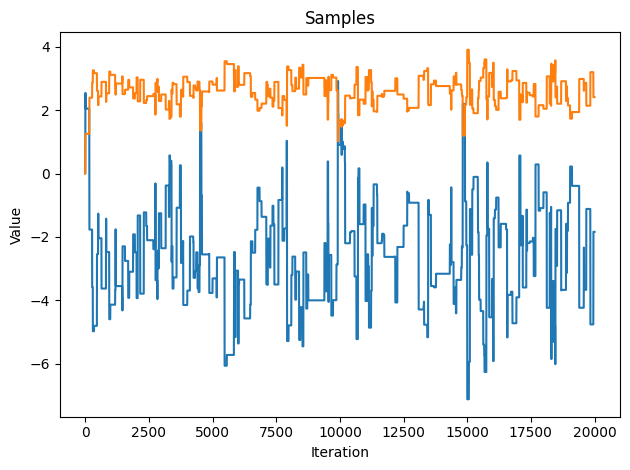

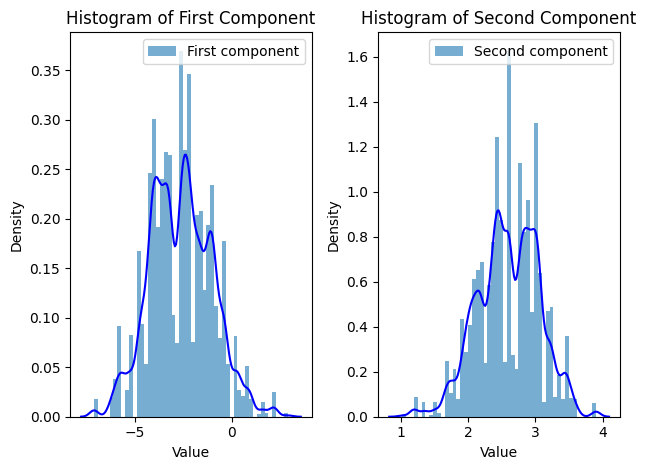

In [82]:
prop_var = 2.38**2  # variance of proposal
burn_in_ratio = 0.1
noise_level = 0.03

samples_after_burn_in = RWMA(prop_var, burn_in_ratio, noise_level)

In [83]:
# Task 5: Compare the results of the RMW algorithm with the analytical solution

rwm_mean = np.mean(samples_after_burn_in, axis=0)
rwm_cov = np.cov(samples_after_burn_in, rowvar=False)
print(f"RWM mean: {rwm_mean}")
print(f"RWM covariance: {rwm_cov}")
print(f"Analytical mean: {m}")
print(f"Analytical covariance: {Sigma}")

RWM mean: [-2.61509952  2.60024659]
RWM covariance: [[ 2.55084074 -0.72438554]
 [-0.72438554  0.20703262]]
Analytical mean: [-6215.58634328  2031.08491973]
Analytical covariance: [[ 2.35805922 -0.66433955]
 [-0.66433955  0.18859052]]


/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_19965/2356949021.py:32: RuntimeWarning: invalid value encountered in scalar divide
  accpt_prob = np.min([1, dens_x_/dens_x])


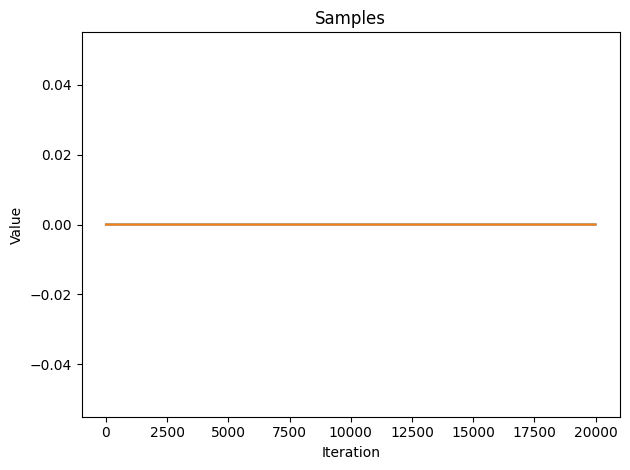

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_19965/2356949021.py:65: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples_after_burn_in[:, 0], ax=axs[0], color='blue')
/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_19965/2356949021.py:72: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(samples_after_burn_in[:, 1], ax=axs[1], color='blue')


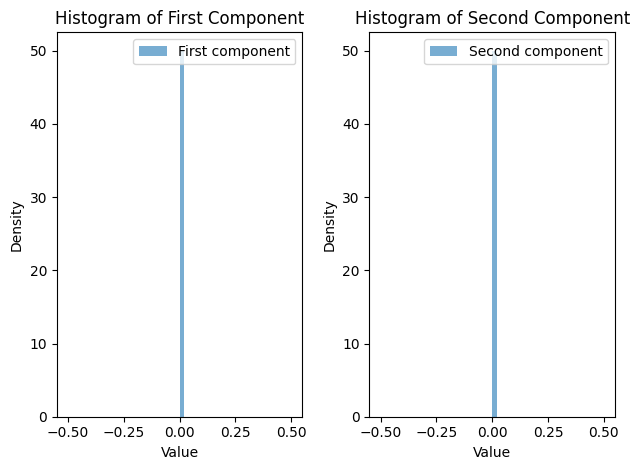

In [84]:
# Task 6: Try prop_var = 0.06**2
prop_var = 0.06**2  # variance of proposal
burn_in_ratio = 0.1
noise_level = 0.03

samples_after_burn_in = RWMA(prop_var, burn_in_ratio, noise_level)
# Result: -> burn-in period is longer, in this case even the whole chain is 0

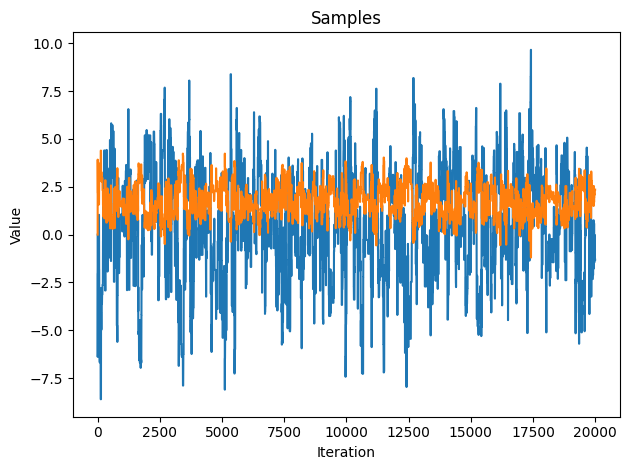

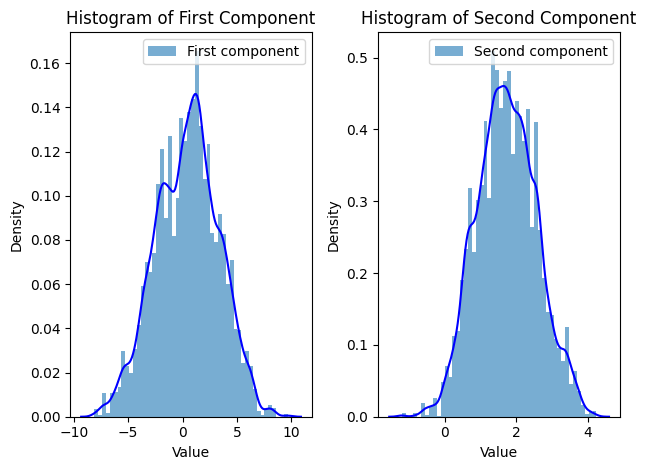

RWM mean: [0.43149616 1.73213726]
RWM covariance: [[ 8.32668962 -2.31950762]
 [-2.31950762  0.69266681]]
Analytical mean: [-6215.58634328  2031.08491973]
Analytical covariance: [[ 2.35805922 -0.66433955]
 [-0.66433955  0.18859052]]


In [85]:
# Task 7: Part 1: Try noise_level = 1
prop_var = 2.38**2
burn_in_ratio = 0.1
noise_level = 1 # original 0.03

samples_after_burn_in = RWMA(prop_var, burn_in_ratio, noise_level)
# Result: -> much more accepted samples, but the mean and covariance are not close to the analytical solution

rwm_mean = np.mean(samples_after_burn_in, axis=0)
rwm_cov = np.cov(samples_after_burn_in, rowvar=False)
print(f"RWM mean: {rwm_mean}")
print(f"RWM covariance: {rwm_cov}")
print(f"Analytical mean: {m}")
print(f"Analytical covariance: {Sigma}")

/var/folders/0n/bb4_kwsn3n5c5_7n_mgl2n540000gn/T/ipykernel_19965/2356949021.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  accpt_prob = np.min([1, dens_x_/dens_x])


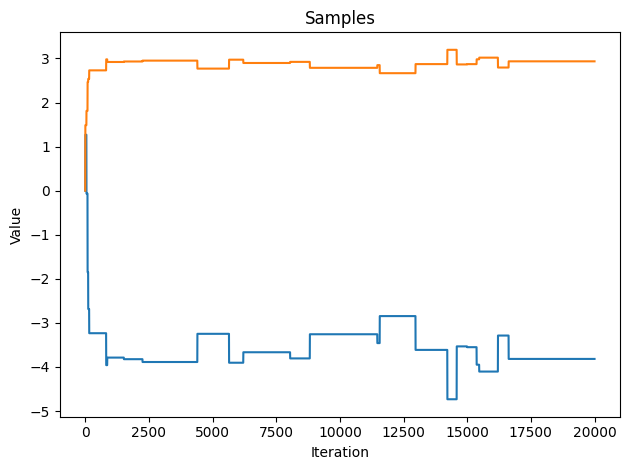

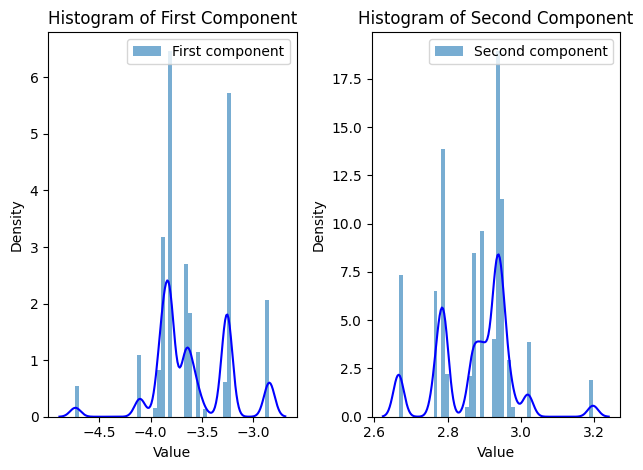

RWM mean: [-3.60533778  2.87782298]
RWM covariance: [[ 0.13468423 -0.03722972]
 [-0.03722972  0.01032577]]
Analytical mean: [-6215.58634328  2031.08491973]
Analytical covariance: [[ 2.35805922 -0.66433955]
 [-0.66433955  0.18859052]]


In [86]:
# Task 7: Part 2: Try noise_level = 0.001
prop_var = 2.38**2
burn_in_ratio = 0.1
noise_level = 0.001 # original 0.03

samples_after_burn_in = RWMA(prop_var, burn_in_ratio, noise_level)
# Result: -> nearly no accepted samples, the mean and covariance are not close to the analytical solution

rwm_mean = np.mean(samples_after_burn_in, axis=0)
rwm_cov = np.cov(samples_after_burn_in, rowvar=False)
print(f"RWM mean: {rwm_mean}")
print(f"RWM covariance: {rwm_cov}")
print(f"Analytical mean: {m}")
print(f"Analytical covariance: {Sigma}")

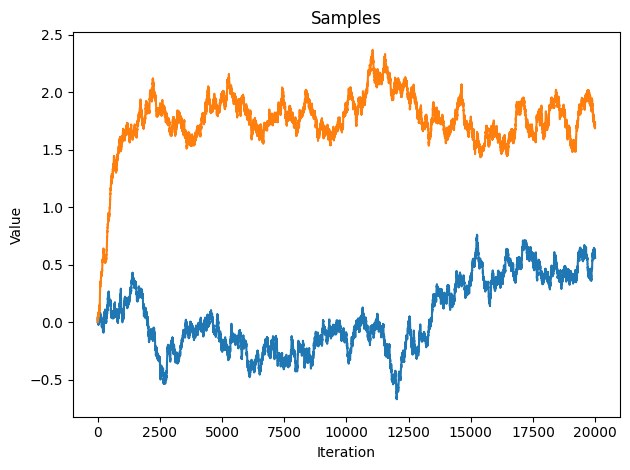

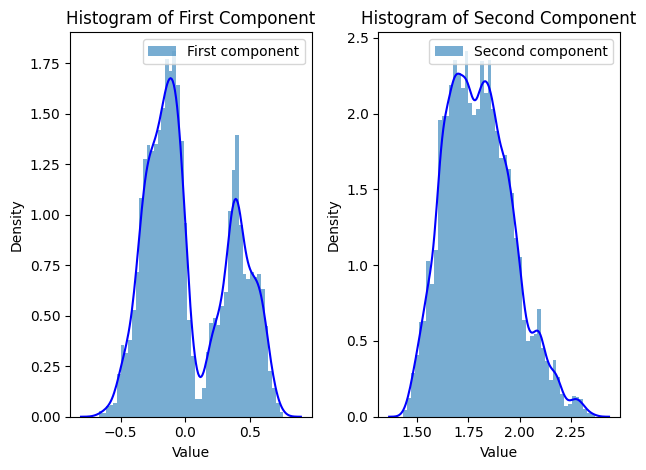

RWM mean: [0.03205113 1.80114205]
RWM covariance: [[ 0.10431436 -0.0171505 ]
 [-0.0171505   0.0270938 ]]
Analytical mean: [-6215.58634328  2031.08491973]
Analytical covariance: [[ 2.35805922 -0.66433955]
 [-0.66433955  0.18859052]]


In [ ]:
# Task 8: set noise level to 0.6 and vary proposal variance (0.01**2, 3**2)
# Part 1: prop_var = 0.01**2
prop_var = 0.01**2
burn_in_ratio = 0.1
noise_level = 0.6 # original 0.03

samples_after_burn_in = RWMA(prop_var, burn_in_ratio, noise_level)
# Result: -> 

rwm_mean = np.mean(samples_after_burn_in, axis=0)
rwm_cov = np.cov(samples_after_burn_in, rowvar=False)
print(f"RWM mean: {rwm_mean}")
print(f"RWM covariance: {rwm_cov}")
print(f"Analytical mean: {m}")
print(f"Analytical covariance: {Sigma}")

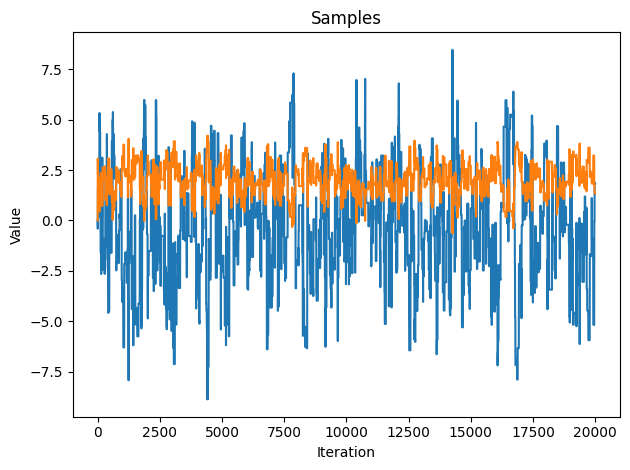

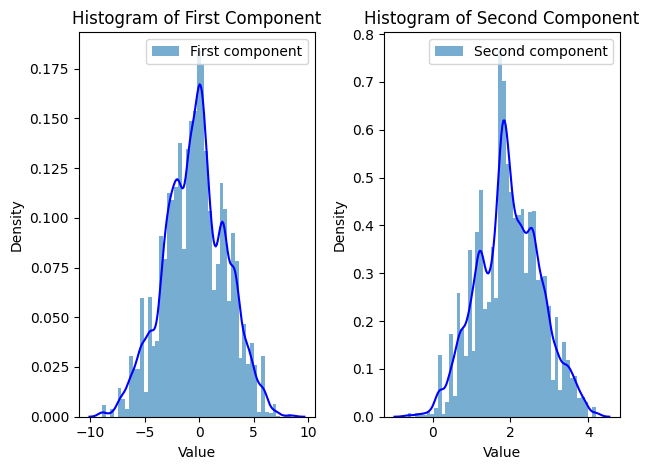

RWM mean: [-0.36245732  1.95921298]
RWM covariance: [[ 7.8089849  -2.20968931]
 [-2.20968931  0.6501054 ]]
Analytical mean: [-6215.58634328  2031.08491973]
Analytical covariance: [[ 2.35805922 -0.66433955]
 [-0.66433955  0.18859052]]


In [88]:
# Task 8: set noise level to 0.6 and vary proposal variance (0.01**2, 3**2)
# Part 1: prop_var = 3**2
prop_var = 3**2
burn_in_ratio = 0.1
noise_level = 0.6 # original 0.03

samples_after_burn_in = RWMA(prop_var, burn_in_ratio, noise_level)
# Result: -> 

rwm_mean = np.mean(samples_after_burn_in, axis=0)
rwm_cov = np.cov(samples_after_burn_in, rowvar=False)
print(f"RWM mean: {rwm_mean}")
print(f"RWM covariance: {rwm_cov}")
print(f"Analytical mean: {m}")
print(f"Analytical covariance: {Sigma}")

In [ ]:
# Task 9: Use different model
#! Not done yet